<a href="https://colab.research.google.com/github/SantiagoJusteValverde/Grupo35_Practica2/blob/main/Grupo35_Practica2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**OBJETIVO DE PREDICCIÓN**

*Crear un modelo que prediga si es probable que los empleados
abandonen la empresa, usando un conjunto de datos recopilados por el departamento de
recursos humanos.*

In [146]:
%matplotlib inline
#######
# Importamos todas las dependencias
import numpy as np
import matplotlib.pyplot as plt


from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn import metrics
# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')
np.random.seed(35)

In [57]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
#path = "/content/drive/MyDrive/Copia Seguridad/D:/santi/Escritorio/Universidad/Quinto/Segundo cuatrimestre/Aprendizaje Automático/Grupo/Aprendizaje Automático/Práctica 2/"
#path="C:/Users/mferh/DataspellProjects/Grupo35_Practica2/"
path= "drive/MyDrive/UC3M/QUINTO/Segundo Cuatrimestre/Aprendizaje Automático/Práctica 2/"

inputFilename = "attrition_available_35.pkl"

In [60]:
import pickle
import pandas as pd

with open(path + inputFilename, 'rb') as f:
    df = pickle.load(f)


y_data_set = df['Attrition']
X_data_set = df.drop('Attrition', axis=1)

#print(X.iloc[0]) #imprimimos la primera columna del conjunto de entrada


In [61]:
"""Mostramos  información acerca de nuestro conjunto de datos"""

# Descripción general del conjunto de datos
print('Información general del conjunto de datos:')
print(X_data_set.info())

# Estadísticas descriptivas de las variables numéricas
print('Estadísticas descriptivas de las variables numéricas:')
print(X_data_set.describe())

Información general del conjunto de datos:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 1 to 4409
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   hrs                      3671 non-null   float64
 1   absences                 3657 non-null   float64
 2   JobInvolvement           3618 non-null   float64
 3   PerformanceRating        3457 non-null   float64
 4   EnvironmentSatisfaction  3630 non-null   float64
 5   JobSatisfaction          3589 non-null   float64
 6   WorkLifeBalance          3514 non-null   float64
 7   Age                      3660 non-null   float64
 8   BusinessTravel           4410 non-null   object 
 9   Department               3702 non-null   object 
 10  DistanceFromHome         3502 non-null   float64
 11  Education                4410 non-null   int64  
 12  EducationField           3444 non-null   object 
 13  EmployeeCount            3603 non-n

Realizamos un análisis de la nulidad de las variables para el conjunto COMPLETO de datos

In [62]:
# Calculamos el número de valores nulos por variable

null_counts = X_data_set.isnull().sum()
null_pct = null_counts / len(X_data_set) * 100
null_df = pd.DataFrame({'Variable': null_counts.index, 'Total Nulos': null_counts.values, '% Nulos': null_pct.values})

# Imprimir el DataFrame con los resultados
print("\n-Valores nulos para cada variable de nuestro conjunto de datos de entrada \n")
display(null_df)



-Valores nulos para cada variable de nuestro conjunto de datos de entrada 



,Variable,Total Nulos,% Nulos
0,hrs,739,16.757370
1,absences,753,17.074830
2,JobInvolvement,792,17.959184
3,PerformanceRating,953,21.609977
4,EnvironmentSatisfaction,780,17.687075
5,JobSatisfaction,821,18.616780
6,WorkLifeBalance,896,20.317460
7,Age,750,17.006803
8,BusinessTravel,0,0.000000
9,Department,708,16.054422


Hallamos el tipo de las distintas variables.

Variables categóricas = [BusinessTravel, Departament, Gender, EducationField, Over18, MaritalStatus, JobRole]



In [63]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
# Obtener una lista de todas las variables en el conjunto de datos
variables_entrada = list(X_data_set.columns)


# Crear una lista de variables categóricas
variables_categoricas = ['BusinessTravel', 'Department', 'Gender', 'EducationField', 'Over18', 'MaritalStatus', 'JobRole']
variables_numericas = []

# Iterar sobre cada variable y comprobar si es de tipo object
for var in variables_entrada:
    if var not in variables_categoricas:
        variables_numericas.append(var)
# Imprimir el número de variables categóricas
print("-El número total de variables categóricas en el conjunto de datos es: ", len(variables_categoricas))
print("-El número total de variables numéricas en el conjunto de datos es: ", len(variables_numericas))

-El número total de variables categóricas en el conjunto de datos es:  7
-El número total de variables numéricas en el conjunto de datos es:  23


Análisis de las variables numéricas

In [64]:
# Calculamos la varianza de las variables numéricas
varianzas = [(var, np.var(X_data_set[var])) for var in variables_numericas]

df_varianzas = pd.DataFrame(varianzas, columns=['Variable', 'Varianza'])

display(df_varianzas)

,Variable,Varianza
0,hrs,1.750385e+00
1,absences,3.062566e+01
2,JobInvolvement,5.088880e-01
3,PerformanceRating,1.275911e-01
4,EnvironmentSatisfaction,1.196964e+00
5,JobSatisfaction,1.220993e+00
6,WorkLifeBalance,4.935591e-01
7,Age,8.265469e+01
8,DistanceFromHome,6.560094e+01
9,Education,1.048200e+00


Observamos como las variables StandardHours tienen un valor constante. Por este mismo motivo, las eliminamos del modelo.

In [65]:
print("Numero de variables previa eliminación:", len(X_data_set.columns))
variables_numericas.remove('StandardHours')
variables_numericas.remove('EmployeeCount')
X_data_set.drop(['StandardHours', 'EmployeeCount'], axis=1, inplace=True)

print("Numero de variables posterior eliminación:", len(X_data_set.columns))


Numero de variables previa eliminación: 30
Numero de variables posterior eliminación: 28


In [66]:
print(X_data_set.columns)

Index(['hrs', 'absences', 'JobInvolvement', 'PerformanceRating',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age',
       'BusinessTravel', 'Department', 'DistanceFromHome', 'Education',
       'EducationField', 'EmployeeID', 'Gender', 'JobLevel', 'JobRole',
       'MaritalStatus', 'MonthlyIncome', 'NumCompaniesWorked', 'Over18',
       'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')


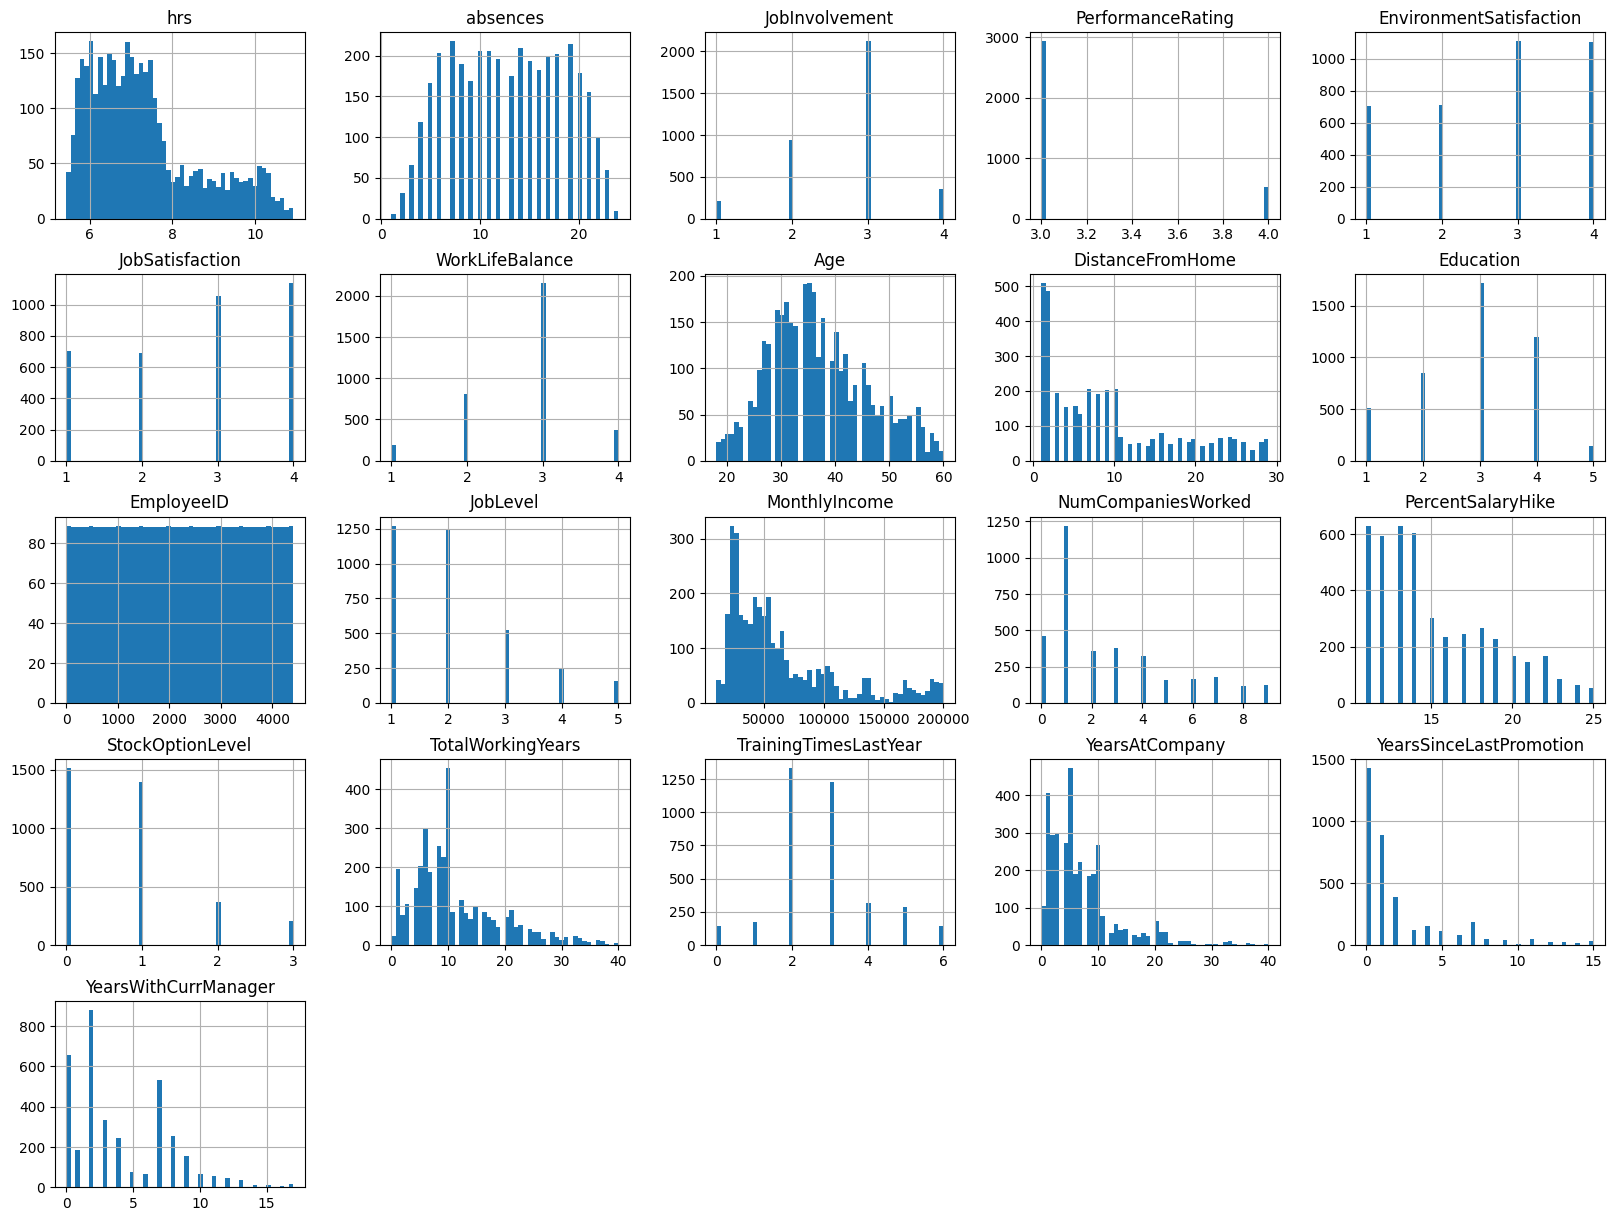

In [67]:
"""HISTOGRAMAS DE NUESTRAS VARIABLES"""
X_data_set.hist(bins=50, figsize=(20,15))
plt.show()



Viendo el gráfico, se puede apreciar como la variable EmployeeID es irrelevante para la predicción del modelo ya que se trata de un identificador único del empleado y no aporta información relevante. Por tanto, la eliminamos también del modelo.

In [68]:
print("Numero de variables previa eliminación:", len(X_data_set.columns))
variables_numericas.remove('EmployeeID')
X_data_set.drop(['EmployeeID'], axis=1, inplace=True)
print("Numero de variables posterior eliminación:", len(X_data_set.columns))


Numero de variables previa eliminación: 28
Numero de variables posterior eliminación: 27


In [69]:
import pandas as pd

# Crear un diccionario vacío para almacenar los resultados
resultados_atipicos = {}

# Recorrer todas las variables numéricas del dataframe
for variable in variables_numericas:
    q1 = X_data_set[variable].quantile(0.25)
    q3 = X_data_set[variable].quantile(0.75)
    iqr = q3 - q1
    lim_inf = q1 - 1.5 * iqr
    lim_sup = q3 + 1.5 * iqr
    outliers = X_data_set[(X_data_set[variable] < lim_inf) | (X_data_set[variable] > lim_sup)][variable]
    num_outliers = len(outliers)
    resultados_atipicos[variable] = {"Num_outliers": num_outliers}

# Crear un dataframe final que contenga todos los resultados
df_resultados_at = pd.DataFrame(resultados_atipicos).T
df_resultados_at.index.name = 'Variable'

display(df_resultados_at)


,Num_outliers
Variable,
hrs,107
absences,0
JobInvolvement,0
PerformanceRating,519
EnvironmentSatisfaction,0
JobSatisfaction,0
WorkLifeBalance,0
Age,0
DistanceFromHome,0


Análisis para variables categóricas

In [70]:
import pandas as pd

# Crear un diccionario vacío para almacenar los resultados
resultados = {}

# Recorrer todas las variables categóricas del dataframe
for variable in variables_categoricas:
    # Calcular la frecuencia para cada valor de la variable
    frecuencias = df[variable].value_counts()
    # Crear un nuevo dataframe con la frecuencia para cada valor de la variable
    df_frecuencias = pd.DataFrame({'Valor': frecuencias.index, 'Frecuencia': frecuencias.values})
    # Agregar el dataframe de frecuencias al diccionario de resultados
    resultados[variable] = df_frecuencias

# Crear un dataframe final que contenga todos los resultados
df_resultados = pd.DataFrame(columns=['Variable', 'Valor', 'Frecuencia'])
for variable, df_frecuencias in resultados.items():
    df_frecuencias['Variable'] = variable
    df_resultados = df_resultados.append(df_frecuencias, ignore_index=True)
df_resultados = df_resultados[['Variable', 'Valor', 'Frecuencia']]

display(df_resultados)

<ipython-input-70-56a0f4e90880>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_resultados = df_resultados.append(df_frecuencias, ignore_index=True)
<ipython-input-70-56a0f4e90880>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_resultados = df_resultados.append(df_frecuencias, ignore_index=True)
<ipython-input-70-56a0f4e90880>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_resultados = df_resultados.append(df_frecuencias, ignore_index=True)
<ipython-input-70-56a0f4e90880>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_resultados = df_resultados.append(df_frecuencias, ignore_index=True)
<ipython-input-70-56a0f4e908

,Variable,Valor,Frecuencia
0,BusinessTravel,Travel_Rarely,3129
1,BusinessTravel,Travel_Frequently,831
2,BusinessTravel,Non-Travel,450
3,Department,Research & Development,2424
4,Department,Sales,1119
5,Department,Human Resources,159
6,Gender,Male,2101
7,Gender,Female,1401
8,EducationField,Life Sciences,1444
9,EducationField,Medical,1066


In [71]:
import pandas as pd

resultados_moda = {}
for variable in variables_categoricas:

    moda = df[variable].mode().values[0]
    df_moda = pd.DataFrame({'Moda': moda}, index=[variable])

    # Calcular el porcentaje de respuestas de la moda respecto al total de respuestas no nulas
    total_no_nulos = df[variable].notnull().sum()
    porcentaje = df[variable].value_counts(normalize=True).loc[moda] * 100

    # Agregar una nueva columna al DataFrame `df_moda` con el porcentaje de respuestas de la moda
    df_moda['Porcentaje'] = f'{porcentaje:.2f}% de {total_no_nulos} respuestas'

    resultados_moda[variable] = df_moda

df_modas = pd.concat(resultados_moda.values())

# Establecer la columna 'Variable' como el índice del DataFrame
df_modas = df_modas.reset_index().set_index('index')
df_modas.index.name = 'Variable'

# Imprimir el DataFrame `df_modas` como una tabla
print('\nModas y porcentajes de respuestas de variables categóricas:\n')
display(df_modas)



Modas y porcentajes de respuestas de variables categóricas:



,Moda,Porcentaje
Variable,,
BusinessTravel,Travel_Rarely,70.95% de 4410 respuestas
Department,Research & Development,65.48% de 3702 respuestas
Gender,Male,59.99% de 3502 respuestas
EducationField,Life Sciences,41.93% de 3444 respuestas
Over18,Y,100.00% de 3545 respuestas
MaritalStatus,Married,45.67% de 3639 respuestas
JobRole,Sales Executive,22.28% de 3618 respuestas


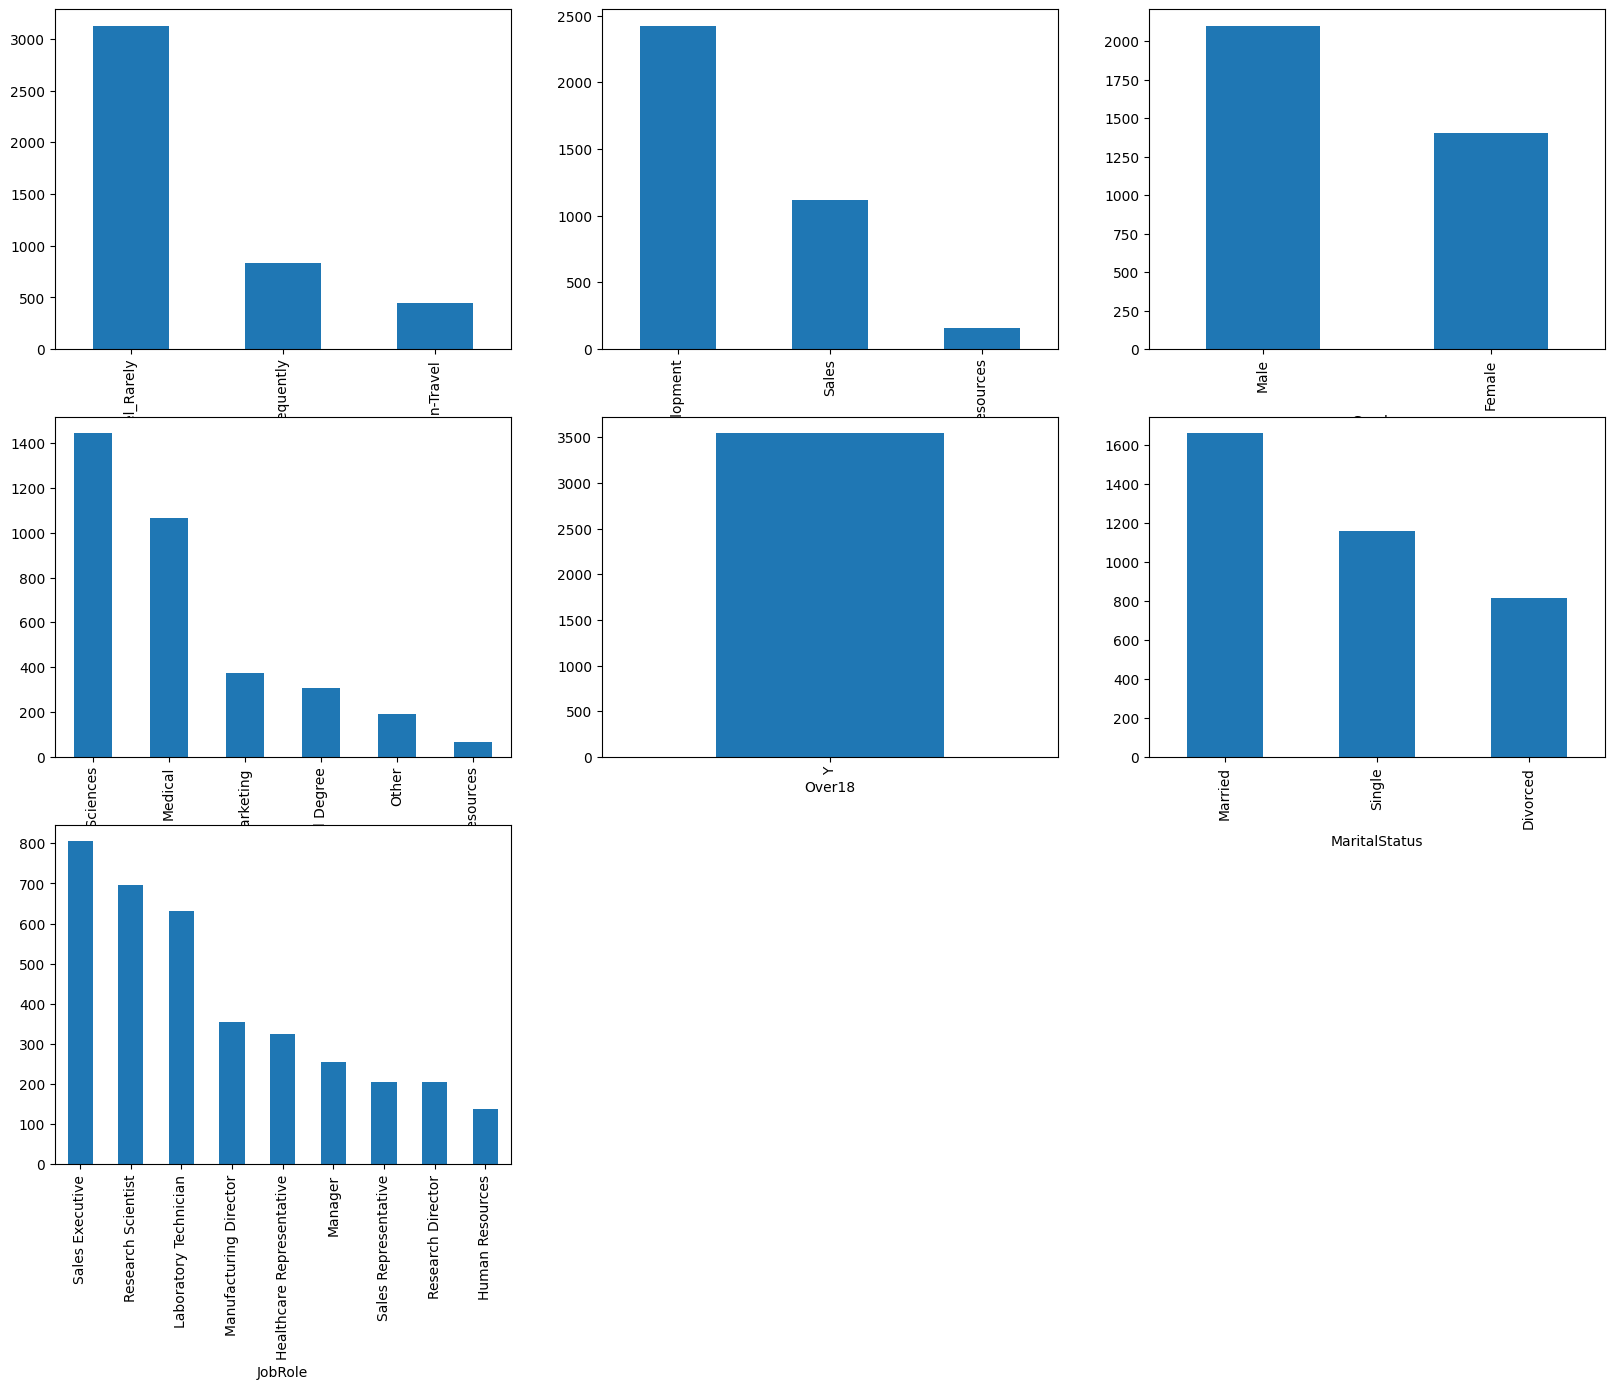

In [72]:
plt.figure(figsize=(20,15))
for i, col in enumerate(variables_categoricas):
    plt.subplot(3, 3, i+1)
    X_data_set[col].value_counts().plot.bar()
    plt.xlabel(col)
plt.show()


Analizando las gráficas y los valores de las variables categóricas existentes, podemos concluir que la variable Over18 es irrelevante al tener el 100% de las muestras el mismo valor. Si bien es cierto que para esta variable existen valores nulos, creemos que estos valores podrían ser también Yes pues la empresa cuenta únicamente con personal mayor de edad. 

Por este motivo, también procederemos a eliminar esta variable del modelo.

In [73]:
print("Numero de variables previa eliminación:", len(X_data_set.columns))
X_data_set.drop(['Over18'], axis=1, inplace=True)
print("Numero de variables posterior eliminación:", len(X_data_set.columns))


Numero de variables previa eliminación: 27
Numero de variables posterior eliminación: 26


#PREPROCESADO

*División del conjunto de datos en entrenamiento y test*


In [74]:
# Seleccionados train/test en modo stratify, ya que el dataset se encuentra desbalanceado
X_train, X_test, y_train, y_test = train_test_split(X_data_set, y_data_set, stratify=y_data_set, test_size=0.33, random_state=35)


Tratamiento de valores nulos para el conjunto de ENTRENAMIENTO

In [75]:
import pandas as pd

# crear un diccionario con los resultados de los análisis
nulidad_train = {
    'Nulos(True/False)': X_train.isnull().any(),
    'Total Nulos': X_train.isnull().sum(),
    '% Nulos': X_train.isnull().sum() / len(X_train) * 100
}

# crear un DataFrame a partir del diccionario
df_nulidad = pd.DataFrame(nulidad_train)

# mostrar el DataFrame
display(df_nulidad)


,Nulos(True/False),Total Nulos,% Nulos
hrs,True,476,16.113744
absences,True,515,17.433988
JobInvolvement,True,542,18.348003
PerformanceRating,True,629,21.293162
EnvironmentSatisfaction,True,525,17.772512
JobSatisfaction,True,542,18.348003
WorkLifeBalance,True,595,20.142180
Age,True,504,17.061611
BusinessTravel,False,0,0.000000
Department,True,508,17.197021


Dibujamos los valores que son nulos

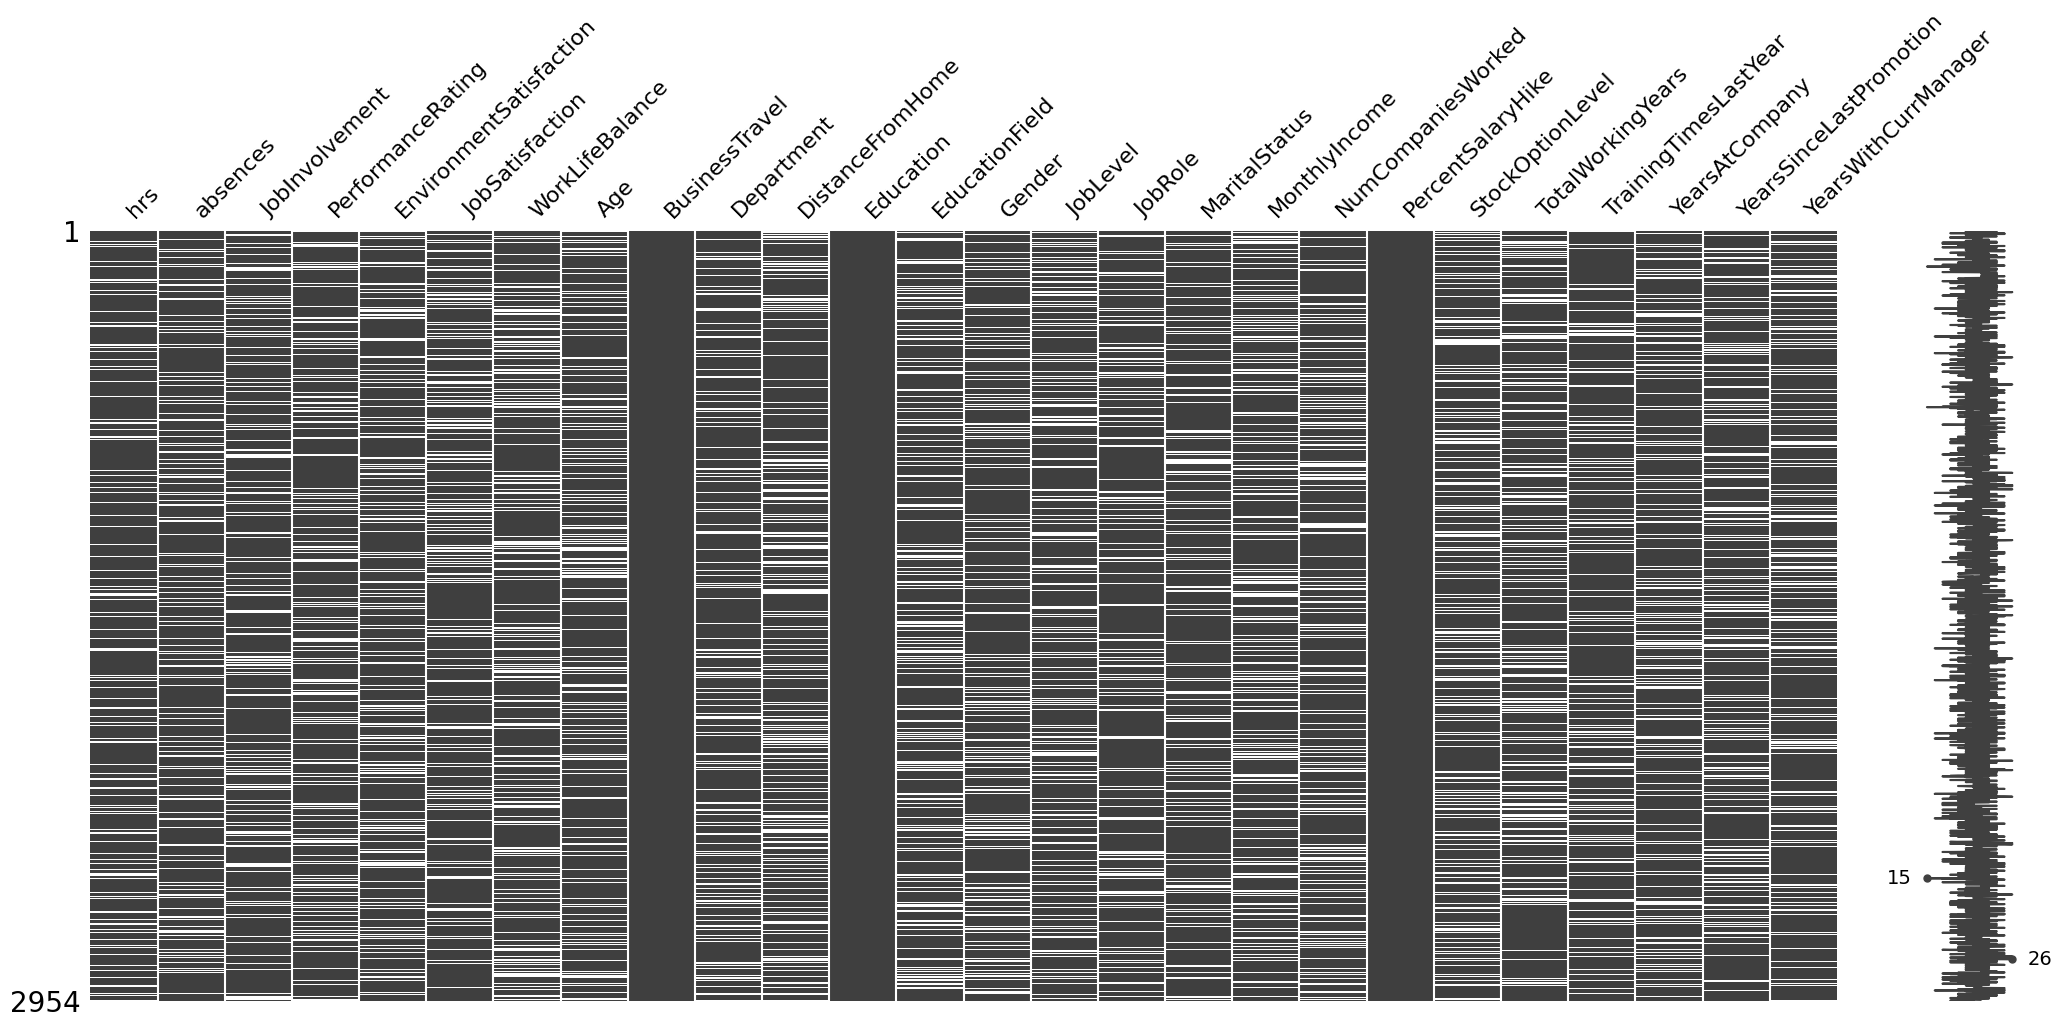

In [76]:
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'png'

msno.matrix(X_train)
plt.show()

#Las entradas son líneas negras, y los huecos blancos

Parece que no hay ninguna variable con un % de nulos suficientemente grande como para no tener sentido imputar esos valores. por lo que no eliminamos ninguna


Vamos a calcular las correlaciones de los valores numéricos

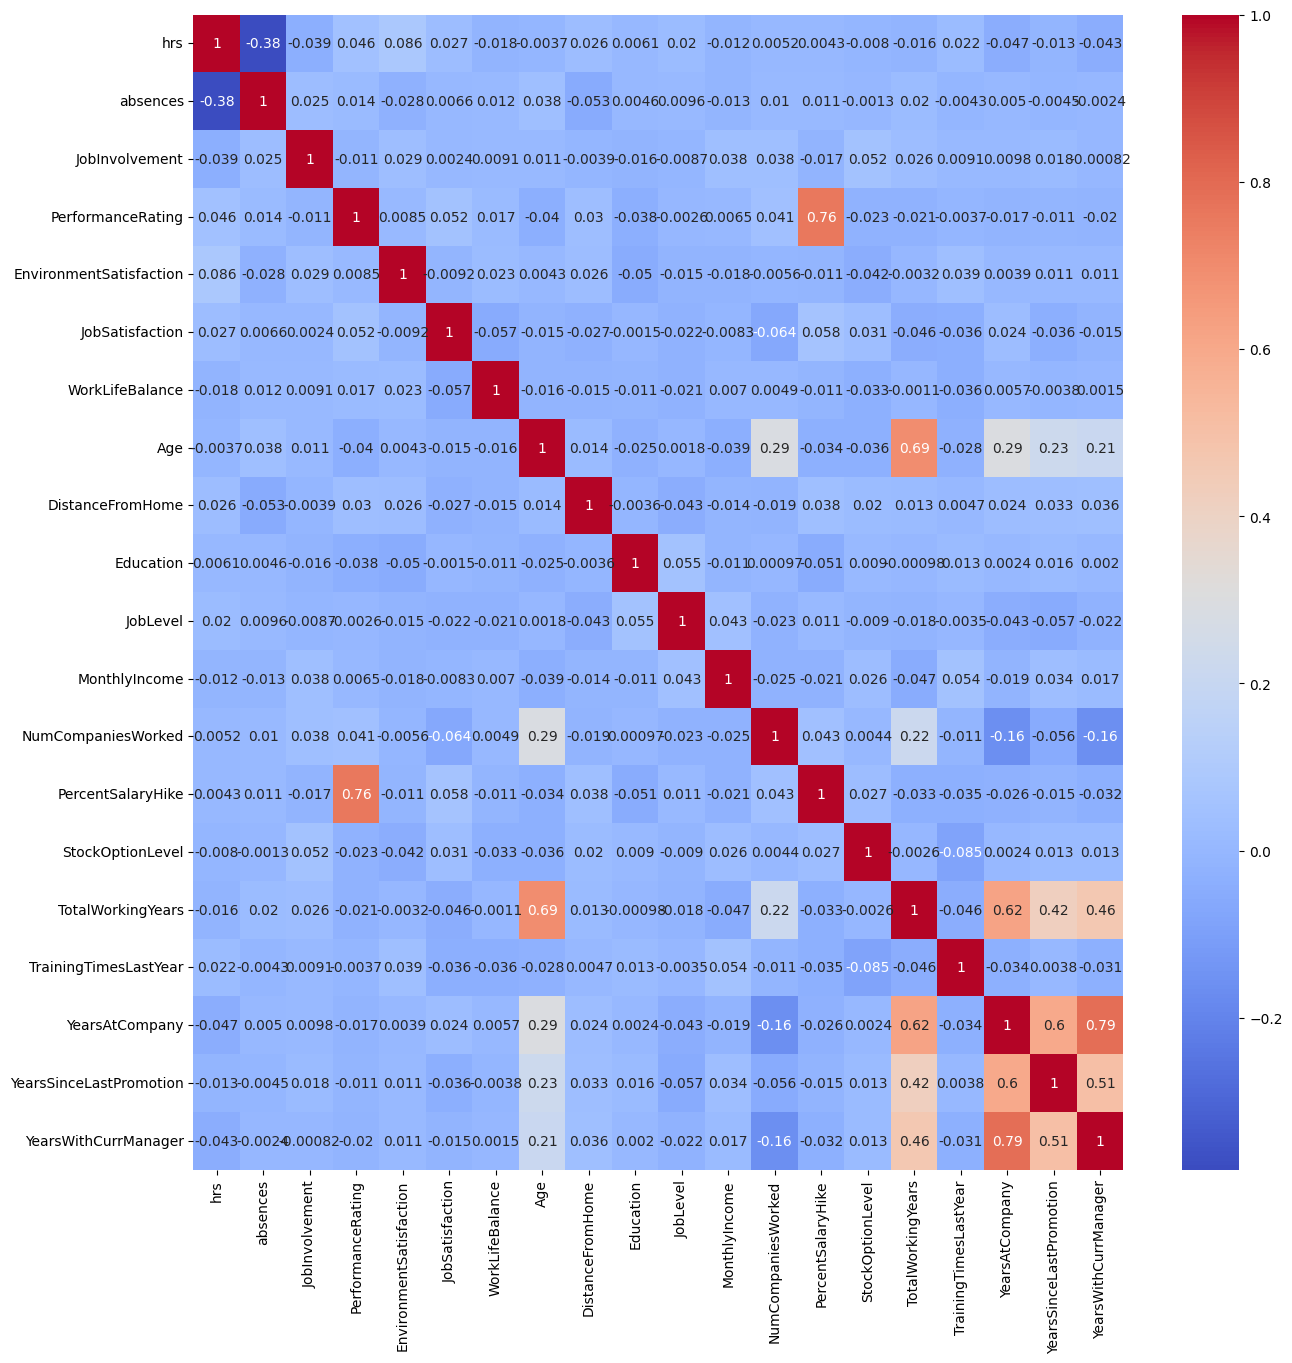

In [77]:
#Ya lo tenemos arriba, aunque solo tiene sentido hacerlo con los numericos, o al menos es lo que hace el
import seaborn as sns
# Seleccionar las variables numéricas del conjunto de entrenamiento
X_train_numeric = X_train[variables_numericas]

# Calcular la matriz de correlación
corr_numerico = X_train_numeric.corr()

fig, ax = plt.subplots(figsize=(15, 15))

# Dibujar la matriz de correlación utilizando un heatmap
sns.heatmap(corr_numerico, annot=True, cmap='coolwarm', ax=ax)
# Mostrar el plot
plt.show()


## Codificamos la salida
Aunque la variable de salida es 0 y 1, pasamos a codificarla con `LabelEncoder` ya que para algunas funciones como el cálculo de las curvas ROC necesitamos esta codificación.

"*El LabelEncoder es útil cuando se tienen variables categóricas que se quieren transformar en variables numéricas, como las etiquetas de clase en un problema de clasificación. En este caso, el LabelEncoder asigna un número entero único a cada categoría, comenzando desde cero.*"

In [78]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_data_set)

y_test = le.transform(y_test)
y_train = le.transform (y_train)

## Analizar tipos de variables
Vamos a analizar las variables categóricas que tenemos en el dataset

In [80]:
from pandas import Index

cat_cols = X_train.select_dtypes(include="object").columns
num_cols = X_train.select_dtypes(exclude="object").columns
cat_cols = cat_cols.difference(['BusinessTravel'])
ord_cols = Index(['BusinessTravel'])



Para las variables categóticas vamos a crear un pipeline donde:
1. Si hubiese una muestra con valores nulos, le vamos a imputar el valor del más frecuente.
2. Codificaremos con la técnicas One_Hot_Encoder.
3. Aplicaremos sobre ellos un PCA, para extraer características más discriminantes

*Hiperparámetros por defecto*

In [81]:
from sklearn.preprocessing import OrdinalEncoder

conv = [['Non-Travel', 'Travel_Rarely', 'Travel_Frequently']]

ord_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Non-Travel')),
    ('ord_encoder', OrdinalEncoder(categories=conv))
])

#ord_transformer.fit(X_train['BusinessTravel'].values.reshape(-1,1), y_train)


In [82]:
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
    ('pca', PCA(n_components=5))
])

In [83]:
# Si queremos acceder al primer paso del pipeline. De la misma forma podríamos acceder a los distintos pasos del pipeline
cat_transformer[0]

SimpleImputer(strategy='most_frequent')

Ahora nos metemos con las variables numéricas. En este caso vamos a realizar el siguiente preproceso:
1. Si hay valores nulos, vamos a asignarles la media de sus K=5 vecinos más cercanos.
2. Realizaremos un escalado

In [84]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler

num_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', RobustScaler())
])

En el siguiente código vamos a utilizar la función `ColumnTransformer` para indicar cómo vamos a preprocesar a las variables categóricas y numéricas

In [93]:
preprocessor = ColumnTransformer(
    transformers=[
        ('ord', ord_transformer, ord_cols),
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
        
    ])
       

In [94]:
preprocessor

ColumnTransformer(transformers=[('ord',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='Non-Travel',
                                                                strategy='constant')),
                                                 ('ord_encoder',
                                                  OrdinalEncoder(categories=[['Non-Travel',
                                                                              'Travel_Rarely',
                                                                              'Travel_Frequently']]))]),
                                 Index(['BusinessTravel'], dtype='object')),
                                ('num',
                                 Pipeline(steps=[('imputer', KNNImputer()),
                                                 ('scaler', RobustScaler())]),
                                 Index(['...
       'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False)),
                                                 ('pca', PCA(n_components=5))]),
                                 Index(['Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus'], dtype='object'))])

In [85]:
unique, frequency = np.unique(y_data_set, 
                              return_counts = True)

uniq = { 'Valor' : unique,
         'Frecuencia': frequency,
        '% valor': (frequency/len(y_data_set))*100
        }
df_uniq = pd.DataFrame(uniq)

display(df_uniq)


,Valor,Frecuencia,% valor
0,No,3699,83.877551
1,Yes,711,16.122449


Observamos como claramente las clases están desbalanceadas. 

## Creamos el clasificador

*REGRESIÓN LOGÍSTICA*


Los parámetros más importantes de la implantación de sklearn (LogisticRegression) son:

- penalty: El tipo de aplicación de regularización. Sus valores pueden ser:{None, 'l2' (por defecto), 'l1', 'elascticnet'}
- C: (por defecto 1.0) Inverso de la fuerza de regularización; Valores más pequeños especifican una regularización más fuerte.
- solver: Algoritmo a utilizar en el problema de optimización. Sus valores pueden ser: {‘lbfgs’ (por defecto), ‘liblinear’, ‘newton-cg’, ‘newton-cholesky’, ‘sag’, ‘saga’}.

Modelo de regresión logística con hiperparámetros por defecto

In [99]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, KFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
lr = LogisticRegression(random_state = 35, class_weight='balanced')


clf_m1 = Pipeline(steps=[('preprocessor', preprocessor),
                      ('scale',scaler),
                      ('classifier', lr)])

Si el valor del parámetro es cv asignado a un número entero y la variable de salida es binaria o multiclase, entonces utiliza StratifiedKFold. Directamente utiliza el valor de shuffle=False. En este caso, lleva a cabo un StratifiedKFold con K=5, y obtenemos el valor medio del accuracy.

In [100]:
clf_m1

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Non-Travel',
                                                                                 strategy='constant')),
                                                                  ('ord_encoder',
                                                                   OrdinalEncoder(categories=[['Non-Travel',
                                                                                               'Travel_Rarely',
                                                                                               'Travel_Frequently']]))]),
                                                  Index(['BusinessTravel'], dtype='object')),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('sc...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('pca',
                                                                   PCA(n_components=5))]),
                                                  Index(['Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus'], dtype='object'))])),
                ('scale', StandardScaler()),
                ('classifier',
                 LogisticRegression(class_weight='balanced', random_state=35))])

In [129]:
scores=cross_val_score(clf_m1, X_train, y_train, cv=5, scoring="balanced_accuracy", error_score='raise')

print(f"All the accuracies are: {scores}")
print(f"And the average crossvalidation accuracy is: {scores.mean():.4f} +- {scores.std():.4f}")


All the accuracies are: [0.66099321 0.68260823 0.74912988 0.69573864 0.67357788]
And the average crossvalidation accuracy is: 0.6924 +- 0.0305


In [105]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Entrenar el modelo
clf_m1.fit(X_train, y_train)

# Predecir las clases en el conjunto de validación
y_pred = clf_m1.predict(X_test)


from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.92      0.70      0.79      1221
           1       0.30      0.67      0.41       235

    accuracy                           0.70      1456
   macro avg       0.61      0.68      0.60      1456
weighted avg       0.82      0.70      0.73      1456



Ahora vamos a hacer un RandomizedSearchCV en busca de los mejores valores para aquellos hiperparámetros que hemos establecido antes.


In [141]:
#@title Texto de título predeterminado
num_transformer_dist = {
    'preprocessor__num__imputer__n_neighbors': list(range(2, 15)),
    'preprocessor__num__imputer__add_indicator': [True, False]
}

cat_transformer_dist = {
    'preprocessor__cat__imputer__strategy': ['most_frequent', 'constant'],
    'preprocessor__cat__imputer__add_indicator': [True, False],
    'preprocessor__cat__pca__n_components': list(range(2, 5))
}

classifier_param_grid_mod1 = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'classifier__penalty': ['l2', 'none']
}


classifier_param_grid_mod2 = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'classifier__solver': [ 'liblinear', 'saga'],
    'classifier__penalty': ['l2','l1']
}



param_dist1 = {**num_transformer_dist, **cat_transformer_dist, **classifier_param_grid_mod1 }
param_dist2 = {**num_transformer_dist, **cat_transformer_dist, **classifier_param_grid_mod2 }

inicio = time.time()
random_search_mod1 = RandomizedSearchCV(clf_m1,
                                   param_distributions=[param_dist1, param_dist2], #--------------------------------------------------------PREGUNTAR SI ESTO FUNCIONA, NO SABEMOS COMO RESTRINGIR LOS PENALTY A LOS DISTINTOS SOLVERS
                                   n_iter=25,
                                   random_state=35,
                                   scoring='balanced_accuracy',
                                   refit=True,
                                   n_jobs=-1,
                                   verbose=1,
                                   return_train_score=True)

random_search_mod1.fit(X_train, y_train)

final = time.time()

print("Tiempo de ejecución de la búsqueda de mejores hiperparámetros: ", (final-inicio)/60)
resultados = pd.DataFrame(random_search_mod1.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head()


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Tiempo de ejecución de la búsqueda de mejores hiperparámetros:  2.96231218179067


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


,param_preprocessor__num__imputer__n_neighbors,param_preprocessor__num__imputer__add_indicator,param_preprocessor__cat__pca__n_components,param_preprocessor__cat__imputer__strategy,param_preprocessor__cat__imputer__add_indicator,param_classifier__solver,param_classifier__penalty,param_classifier__C,mean_test_score,std_test_score,mean_train_score,std_train_score
11,7,False,4,constant,False,saga,none,1,0.704210,0.023815,0.720563,0.008113
10,7,True,4,constant,False,lbfgs,l2,0.01,0.703496,0.022266,0.719928,0.003639
23,9,True,4,constant,False,lbfgs,l2,0.1,0.696777,0.023624,0.720897,0.006086
8,12,True,4,constant,False,sag,none,0.001,0.695564,0.025226,0.721501,0.006202
1,14,False,3,most_frequent,False,lbfgs,none,100,0.695150,0.027374,0.715426,0.007975


In [142]:




print("Mejores hiperparámetros encontrados",random_search_mod1.best_params_)
print("Mejores balanced_accuracy de entrenamiento:", random_search_mod1.best_score_)
y_pred = random_search_mod1.predict(X_test)

print("/n")

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

from sklearn.metrics import balanced_accuracy_score

print(f"\nEl valor de balanced accuracy test: {balanced_accuracy_score(y_test, y_pred)}")

Mejores hiperparámetros encontrados {'preprocessor__num__imputer__n_neighbors': 7, 'preprocessor__num__imputer__add_indicator': False, 'preprocessor__cat__pca__n_components': 4, 'preprocessor__cat__imputer__strategy': 'constant', 'preprocessor__cat__imputer__add_indicator': False, 'classifier__solver': 'saga', 'classifier__penalty': 'none', 'classifier__C': 1}
Mejores balanced_accuracy: 0.7042099153675979
/n
              precision    recall  f1-score   support

           0       0.92      0.71      0.80      1221
           1       0.31      0.69      0.43       235

    accuracy                           0.70      1456
   macro avg       0.61      0.70      0.61      1456
weighted avg       0.82      0.70      0.74      1456


El valor de balanced accuracy: 0.6951330440692143


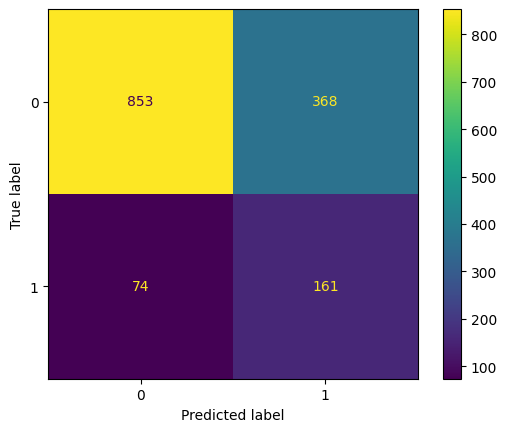

In [135]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_test, y_pred, labels=random_search.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=random_search.classes_)
disp.plot()
plt.show()

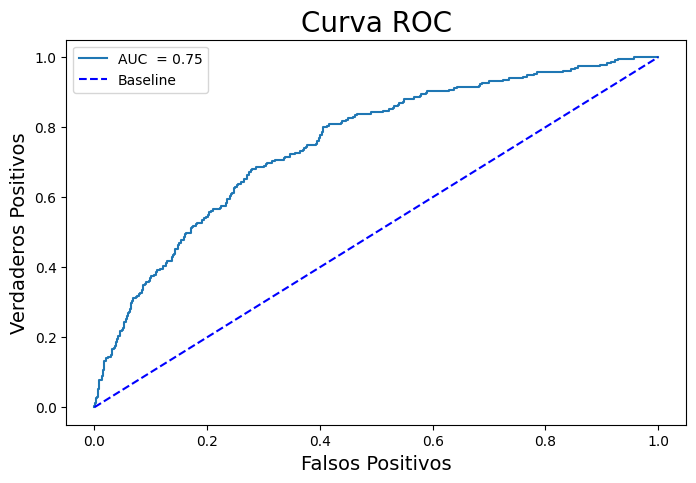

In [144]:
#Obtenemos las curva ROC y el área bajo la curva (AUC)

probs = random_search_mod1.predict_proba(X_test)[:, 1]

auc = metrics.roc_auc_score(y_test, probs)
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'AUC  = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('Curva ROC', size=20)
plt.xlabel('Falsos Positivos', size=14)
plt.ylabel('Verdaderos Positivos', size=14)
plt.legend();

# HistGradientBoostingRegressor
Los parámetros más importantes de la implantación de sklearn (`HistGradientBoostingRegressor`) para controlar el crecimiento de los árboles, la velocidad de aprendizaje del modelo, y los que gestionan la parada temprana para evitar *overfitting*, son:

- `learning_rate`: reduce la contribución de cada árbol multiplicando su influencia original por este valor.
- `max_iter`: El número máximo de iteraciones del proceso de boosting, es decir, el número máximo de árboles.
- `max_depth`: profundidad máxima que pueden alcanzar los árboles.
- `min_samples_split`: número mínimo de observaciones que debe de tener un nodo para que pueda dividirse. Si es un valor decimal se interpreta como fracción del total de observaciones de entrenamiento `ceil(min_samples_split * n_samples)`.
- `min_samples_leaf`: número mínimo de observaciones que debe de tener cada uno de los nodos hijos para que se produzca la división. Si es un valor decimal se interpreta como fracción del total de observaciones de entrenamiento `ceil(min_samples_split * n_samples)`.
- `validation_fraction`: proporción de datos separados del conjunto entrenamiento y empleados como conjunto de validación para determinar la parada temprana (*early stopping*).
- `n_iter_no_change`: número de iteraciones consecutivas en las que no se debe superar el tol para que el algoritmo se detenga (*early stopping*). Si su valor es None se desactiva la parada temprana.
- `tol`: porcentaje mínimo de mejora entre dos iteraciones consecutivas por debajo del cual se considera que el modelo no ha mejorado.


*Modelo con hiperparámetros por defecto*

class sklearn.ensemble.HistGradientBoostingClassifier(loss='log_loss', *, learning_rate=0.1, max_iter=100, max_leaf_nodes=31, max_depth=None, min_samples_leaf=20, l2_regularization=0.0, max_bins=255, categorical_features=None, monotonic_cst=None, interaction_cst=None, warm_start=False, early_stopping='auto', scoring='loss', validation_fraction=0.1, n_iter_no_change=10, tol=1e-07, verbose=0, random_state=None, class_weight=None)[source]¶

In [148]:
# Creación del modelo
# ==============================================================================
from sklearn.ensemble import HistGradientBoostingClassifier
import time
cl_gb = HistGradientBoostingClassifier(
            random_state = 35, class_weight='balanced') 

clf_m2 = Pipeline(steps=[('preprocessor', preprocessor),                      
                      ('classifier', cl_gb)])


clf_m2.fit(X_train, y_train)
# Predecir sobre conjunto de test
y_pred = clf_m2.predict(X_test)
y_proba = clf_m2.predict_proba(X_test)[:, 1]

# Reporte de clasificación
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1221
           1       0.73      0.64      0.68       235

    accuracy                           0.90      1456
   macro avg       0.83      0.80      0.81      1456
weighted avg       0.90      0.90      0.90      1456



In [151]:
scores=cross_val_score(clf_m2, X_train, y_train, cv=5, scoring="balanced_accuracy", error_score='raise')

print(f"All the accuracies are: {scores}")
print(f"And the average crossvalidation accuracy is: {scores.mean():.4f} +- {scores.std():.4f}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


All the accuracies are: [0.7883489  0.75777801 0.80313031 0.80372475 0.76400851]
And the average crossvalidation accuracy is: 0.7834 +- 0.0193


AUC-ROC: 0.9156707965218605


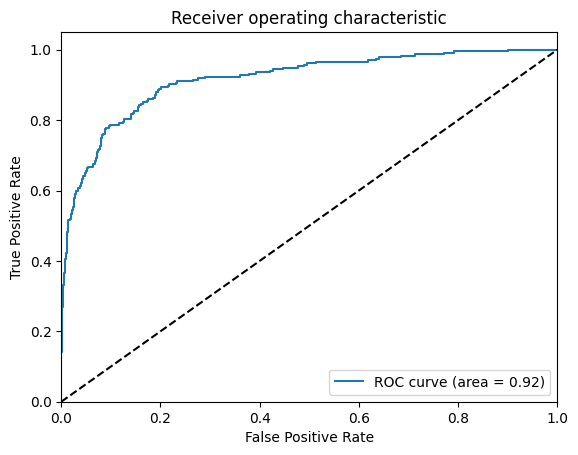

In [150]:
# AUC-ROC
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

auc_roc = roc_auc_score(y_test, y_proba)
print("AUC-ROC:", auc_roc)

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()